In [ ]:
"""
Kidney CT Scan Dataset Preprocessing
- Duplicate removal using MD5 hashing
- Stratified train/test split (70/30)
- Dataset normalization statistics
"""

import os
import shutil
import hashlib
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

RAW_DATA_PATH = '../data/raw-2D-CT-Kidney'
PROCESSED_PATH = '../data/processed'
OUTPUT_DIR = '../outputs/figures'
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PROCESSED_PATH, exist_ok=True)
np.random.seed(SEED)

print(f"Raw data: {RAW_DATA_PATH}")
print(f"Output: {PROCESSED_PATH}")
print(f"\nData Split Strategy:")
print(f"  - 70% Training")
print(f"  - 30% Test (held out for final evaluation)")

Raw data: ../data/raw-2D-CT-Kidney
Output: ../data/processed


## 1. Dataset Statistics

In [2]:
class_names = sorted([d for d in os.listdir(RAW_DATA_PATH) 
                      if os.path.isdir(os.path.join(RAW_DATA_PATH, d))])
all_files = {}

print("=" * 50)
print("DATASET STATISTICS")
print("=" * 50)

total = 0
for class_name in class_names:
    class_path = os.path.join(RAW_DATA_PATH, class_name)
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_files[class_name] = files
    total += len(files)
    print(f"{class_name}: {len(files):,}")

print(f"\nTotal: {total:,} images across {len(class_names)} classes")

DATASET STATISTICS
Cyst: 3,709
Normal: 5,077
Stone: 2,954
Tumor: 2,283

Total: 14,023 images across 4 classes


## 2. Remove Duplicates

In [3]:
def compute_hash(filepath):
    """MD5 hash for duplicate detection."""
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

print("Scanning for duplicates...")
hash_to_file = {}
duplicates = []
unique_files = {c: [] for c in class_names}

for class_name in tqdm(class_names):
    class_path = os.path.join(RAW_DATA_PATH, class_name)
    for filename in all_files[class_name]:
        filepath = os.path.join(class_path, filename)
        file_hash = compute_hash(filepath)
        
        if file_hash in hash_to_file:
            duplicates.append((filepath, hash_to_file[file_hash]))
        else:
            hash_to_file[file_hash] = filepath
            unique_files[class_name].append(filename)

print(f"\nDuplicates found: {len(duplicates)}")
print(f"Unique images: {len(hash_to_file):,}")

# Summary table
total_before, total_after = 0, 0
print(f"\n{'Class':12} {'Before':>10} {'After':>10} {'Removed':>10}")
print("-" * 45)
for class_name in class_names:
    before, after = len(all_files[class_name]), len(unique_files[class_name])
    total_before += before
    total_after += after
    print(f"{class_name:12} {before:>10,} {after:>10,} {before - after:>10,}")
print("-" * 45)
print(f"{'TOTAL':12} {total_before:>10,} {total_after:>10,} {total_before - total_after:>10,}")

Scanning for duplicates...


100%|██████████| 4/4 [00:52<00:00, 13.05s/it]


Duplicates found: 578
Unique images: 13,445

Class            Before      After    Removed
---------------------------------------------
Cyst              3,709      3,284        425
Normal            5,077      5,002         75
Stone             2,954      2,876         78
Tumor             2,283      2,283          0
---------------------------------------------
TOTAL            14,023     13,445        578


## 3. Create Stratified Train/Test Split (70/30)
- **Training (70%)**: Used for model training
- **Test (30%)**: Held out for final evaluation

In [ ]:
# Prepare data for stratified splitting
all_images = [(c, f) for c in class_names for f in unique_files[c]]
all_labels = [c for c, _ in all_images]

# 70% train, 30% test
train_data, test_data, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.30, stratify=all_labels, random_state=SEED)

print(f"Train: {len(train_data):,} ({len(train_data)/len(all_images)*100:.0f}%)")
print(f"Test:  {len(test_data):,} ({len(test_data)/len(all_images)*100:.0f}%)")

Train: 9,411 (70%)
Val:   2,017 (15%)
Test:  2,017 (15%)


In [ ]:
# Verify class balance is preserved across splits
print(f"{'Class':10} {'Train':>8} {'Test':>8}")
print("-" * 30)
for c in class_names:
    t = sum(1 for lbl in train_labels if lbl == c)
    s = sum(1 for lbl in test_labels if lbl == c)
    print(f"{c:10} {t:8} {s:8}")

Class         Train      Val     Test
----------------------------------------
Cyst           2299      492      493
Normal         3501      751      750
Stone          2013      431      432
Tumor          1598      343      342


## 4. Copy Files to Processed Folder

In [ ]:
def copy_split_data(data_list, split_name):
    """Copy images to processed directory structure."""
    split_path = os.path.join(PROCESSED_PATH, split_name)
    for c in class_names:
        os.makedirs(os.path.join(split_path, c), exist_ok=True)
    
    for class_name, filename in tqdm(data_list, desc=split_name):
        src = os.path.join(RAW_DATA_PATH, class_name, filename)
        dst = os.path.join(split_path, class_name, filename)
        shutil.copy2(src, dst)

# Clear and recreate
for split in ['train', 'test']:
    split_path = os.path.join(PROCESSED_PATH, split)
    if os.path.exists(split_path):
        shutil.rmtree(split_path)

# Remove old val folder if it exists
val_path = os.path.join(PROCESSED_PATH, 'val')
if os.path.exists(val_path):
    shutil.rmtree(val_path)
    print("Removed old 'val' folder")

copy_split_data(train_data, 'train')
copy_split_data(test_data, 'test')
print("\n✓ Dataset created (70% train / 30% test)")

test: 100%|██████████| 2017/2017 [00:01<00:00, 1593.74it/s]


✓ Dataset created


In [ ]:
# Verify final structure
for split in ['train', 'test']:
    split_path = os.path.join(PROCESSED_PATH, split)
    total_split = sum(len(os.listdir(os.path.join(split_path, c))) for c in class_names)
    print(f"{split.upper()}: {total_split:,} images")

TRAIN: 9,411 images
VAL: 2,017 images
TEST: 2,017 images


## 5. Calculate Dataset Normalization Stats

In [ ]:
# Compute channel-wise mean and std from training set only (prevents data leakage)
calc_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_path = os.path.join(PROCESSED_PATH, 'train')
calc_dataset = ImageFolder(train_path, transform=calc_transform)
calc_loader = DataLoader(calc_dataset, batch_size=128, shuffle=False, num_workers=4)

mean, std = torch.zeros(3), torch.zeros(3)
n_samples = 0

for images, _ in tqdm(calc_loader, desc="Computing stats"):
    b = images.size(0)
    images = images.view(b, 3, -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += b

mean /= n_samples
std /= n_samples

# Save configuration for model notebooks
config = {
    'data_path': os.path.abspath(PROCESSED_PATH),
    'image_size': 224,
    'num_classes': len(class_names),
    'class_names': class_names,
    'mean': mean.tolist(),
    'std': std.tolist(),
    'train_size': len(train_data),
    'test_size': len(test_data),
    'split_ratio': '70/30'
}

config_file = '../data/dataset_config.json'
with open(config_file, 'w') as f:
    json.dump(config, f, indent=2)

print(f"Mean: [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
print(f"Std:  [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")
print(f"\nConfig saved: {config_file}")

Computing stats: 100%|██████████| 74/74 [00:22<00:00,  3.27it/s]

Mean: [0.1451, 0.1451, 0.1451]
Std:  [0.2177, 0.2177, 0.2177]

Config saved: ../data/dataset_config.json


## 6. Final Summary

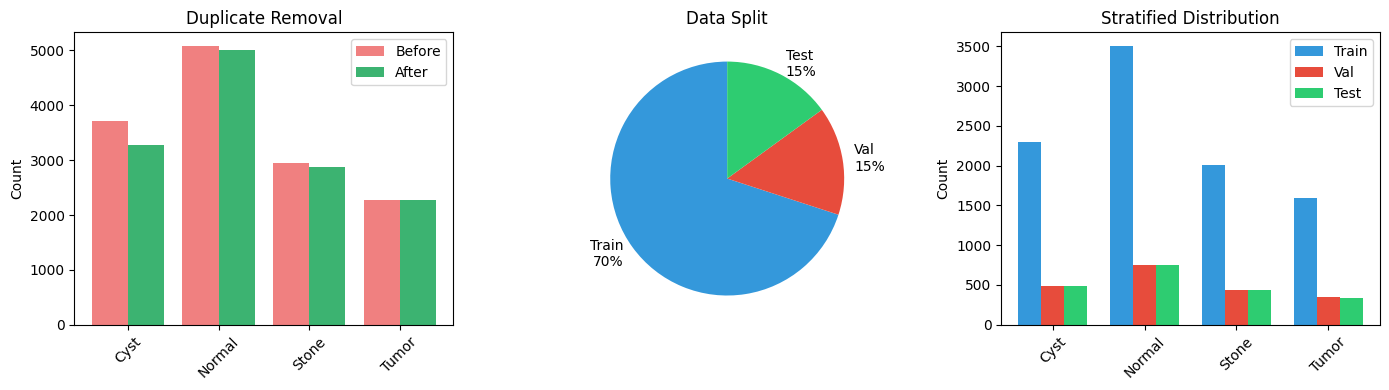


✓ Processing complete
  Train: 9,411 | Val: 2,017 | Test: 2,017


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Duplicate removal impact
x = np.arange(len(class_names))
before_counts = [len(all_files[c]) for c in class_names]
after_counts = [len(unique_files[c]) for c in class_names]
axes[0].bar(x - 0.2, before_counts, 0.4, label='Before', color='lightcoral')
axes[0].bar(x + 0.2, after_counts, 0.4, label='After', color='mediumseagreen')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].set_ylabel('Count')
axes[0].set_title('Duplicate Removal')
axes[0].legend()

# Split distribution (70/30)
split_sizes = [len(train_data), len(test_data)]
axes[1].pie(split_sizes, labels=['Train\n70%', 'Test\n30%'], 
            colors=['#3498db', '#2ecc71'], startangle=90,
            explode=(0.02, 0.02))
axes[1].set_title('Data Split (70/30)')

# Class distribution per split
train_counts = [sum(1 for lbl in train_labels if lbl == c) for c in class_names]
test_counts = [sum(1 for lbl in test_labels if lbl == c) for c in class_names]
w = 0.35
axes[2].bar(x - w/2, train_counts, w, label='Train (70%)', color='#3498db')
axes[2].bar(x + w/2, test_counts, w, label='Test (30%)', color='#2ecc71')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names, rotation=45)
axes[2].set_ylabel('Count')
axes[2].set_title('Stratified Distribution')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'data_summary.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Processing complete")
print(f"  Train: {len(train_data):,} (70%)")
print(f"  Test:  {len(test_data):,} (30%)")